In [4]:
from numpy import *
import torch
import random
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# 数据预处理，训练集和验证集七三分

dtype = torch.FloatTensor

mem = Memory("./mycache")
@mem.cache
def get_data():
    data = load_svmlight_file("data/australian_scale.txt")
    return data[0], data[1]

x, y = get_data()

x_train, x_vali, y_train, y_vali = train_test_split(x, y, test_size=0.30, random_state=42)

# 483 x 14
x_train = x_train.toarray()
x_train = torch.from_numpy(x_train).type(dtype)
# print(x_train.size())

# 483 x 1
y_train = array(y_train).reshape(size(y_train,0),1)
y_train = torch.from_numpy(y_train).type(dtype)
# print(y_train.size())

# 207 x 14
x_vali = x_vali.toarray()
x_vali = torch.from_numpy(x_vali).type(dtype)
# print(x_vali.size())

# 207 x 1
y_vali = array(y_vali).reshape(size(y_vali,0),1)
y_vali = torch.from_numpy(y_vali).type(dtype)
# print(y_vali.size())

# 最大特征数 14
num_feature = max(x_train.size(1), x_vali.size(1))

bias = torch.ones(1, x_train.size(0))
bias = bias.t()
x_train = torch.cat((x_train, bias), 1)

bias = torch.ones(1, x_vali.size(0))
bias = bias.t()
x_vali = torch.cat((x_vali, bias), 1)

w = []

# 全零初始化
w.append(torch.zeros(num_feature + 1, 1))

# 阈值
threshold = 0
# 学习率
l_r = 0.005
#超参数
tradeoff = 0.01
# 训练集规模
len_train = x_train.size(0)
# 验证集规模
len_vali = x_vali.size(0)
#迭代次数
time_iteration = 1000

iteras = arange(1, time_iteration+1)
Loss_train = []
Loss_vali = []

In [6]:
# 开始迭代
print("开始计算，迭代次数：" + str(time_iteration))
for k in range(time_iteration):
    Loss_sum = 0
    grad_E = 0
    # 迭代训练集
    for l in range(len_train):
        E = y_train[l][0] * torch.mm(w[k].t(), x_train[l:l+1, :].t())
        if E[0][0] < 1:
            Loss_sum += 1-E[0][0]
            grad_E += y_train[l][0] * x_train[l:l+1, :].t()
    grad = w[k] - tradeoff * grad_E
    grad[-1][0] -= w[k][-1][0]
    direction = -grad
    w.append(w[k] + l_r * direction)
    Loss_sum *= tradeoff
    Loss_sum += square(torch.norm(w[k])) / 2
    Loss = Loss_sum / len_train
    Loss_train.append(Loss)

    # 迭代验证集
    Loss_sum = 0
    for l in range(len_vali):
        E = y_vali[l][0] * torch.mm(w[k].t(), x_vali[l:l+1, :].t())
        if E[0][0] < 1:
            Loss_sum += 1-E[0][0]
    Loss_sum *= tradeoff
    Loss_sum += square(torch.norm(w[k])) / 2
    Loss = Loss_sum / len_vali
    Loss_vali.append(Loss)

开始计算，迭代次数：1000


In [7]:
# 测试准确率
time = 0
for l in range(len_vali):
    predict = torch.mm(w[time_iteration].t(), x_vali[l:l+1, :].t())
    if predict[0][0] > 0 :
        predict = 1
    else:
        predict = -1
    if predict == y_vali[l][0]:
        time += 1
print('准确率：' + str(time/len_vali))

准确率：0.8502415458937198


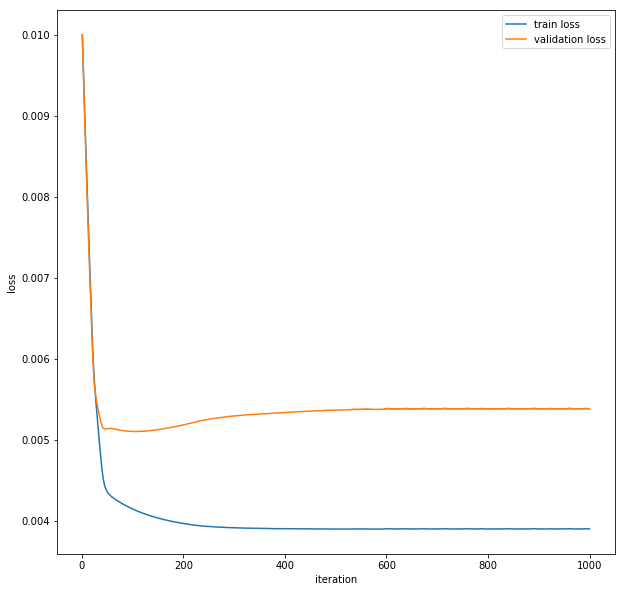

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(iteras, Loss_train, label = "train loss")
plt.plot(iteras, Loss_vali, label = "validation loss")
plt.legend(loc = 'best')
plt.show()